In [1]:
import requests
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import json
import io
import sys
import base64
from torch.utils.data import Dataset
from typing import Tuple
import pickle
import os


# Your API client
from api_client import APIClient

# Paths & Token
DATA_PATH   = "data\\ModelStealingPub.pt"
OUTPUT_FILE = "data\\public_embeddings.npz"
TOKEN       = "09596680"   # <-- your token


In [2]:
# Initialize and launch the API client
client = APIClient(token=TOKEN)
client.launch()   # prints seed & port

print(f"⚙️  Session seed: {client.seed}")
print(f"⚙️  Session port: {client.port}")

[API] Launched: seed=61437433, port=9732
⚙️  Session seed: 61437433
⚙️  Session port: 9732


In [ ]:
# for reusing port 

# client_a = APIClient(token=TOKEN)
# client_a.seed = "1234567"   # replace with your actual seed
# client_a.port = "9002"      # replace with your actual port
# print(f"[API] Reusing session: seed={client.seed}, port={client.port}")


[API] Reusing session: seed=None, port=None


In [3]:
# --- Begin: Dataset class definitions needed for torch.load ---
import torch
from torch.utils.data import Dataset
from typing import Tuple

class TaskDataset(Dataset):
    def __init__(self, transform=None):
        self.ids = []
        self.imgs = []
        self.labels = []
        self.transform = transform

    def __getitem__(self, index) -> Tuple[int, torch.Tensor, int]:
        id_ = self.ids[index]
        img = self.imgs[index]
        if self.transform:
            img = self.transform(img)
        label = self.labels[index]
        return id_, img, label

    def __len__(self):
        return len(self.ids)
# --- End: Dataset class definitions ---


In [4]:
def model_stealing(images, port):
    endpoint = "/query"
    url = f"http://34.122.51.94:{port}" + endpoint
    image_data = []
    for img in images:
        img_byte_arr = io.BytesIO()
        img.save(img_byte_arr, format='PNG')
        img_byte_arr.seek(0)
        img_base64 = base64.b64encode(img_byte_arr.getvalue()).decode('utf-8')
        image_data.append(img_base64)

    payload = json.dumps(image_data)
    response = requests.get(url, files={"file": payload}, headers={"token": TOKEN})
    if response.status_code == 200:
        representation = response.json()["representations"]
        return representation
    else:
        raise Exception(
            f"Model stealing failed. Code: {response.status_code}, content: {response.json()}"
        )

Dataset length: 13000


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

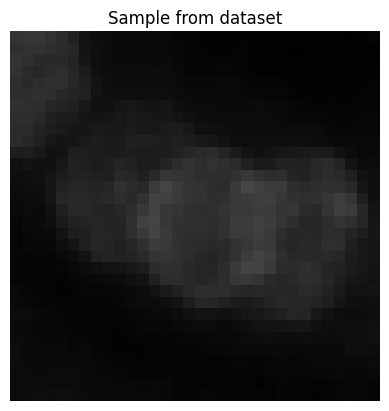

In [7]:
# Load the .pt public dataset
dataset = torch.load("F:\\TML_model_stealing\\TML25_A2_39\\data\\ModelStealingPub.pt", weights_only=False)
print("Dataset length:", len(dataset.ids))

# Show one sample image
# Check the type of the image
img = dataset.imgs[15]
if isinstance(img, torch.Tensor):
    to_pil = transforms.ToPILImage()
    img = to_pil(img)
elif not isinstance(img, Image.Image):
    raise TypeError(f"Unexpected type: {type(img)}")

plt.imshow(img)
plt.title(f"Sample from dataset")
plt.axis('off')


✅ Received embeddings: (1000, 1024)


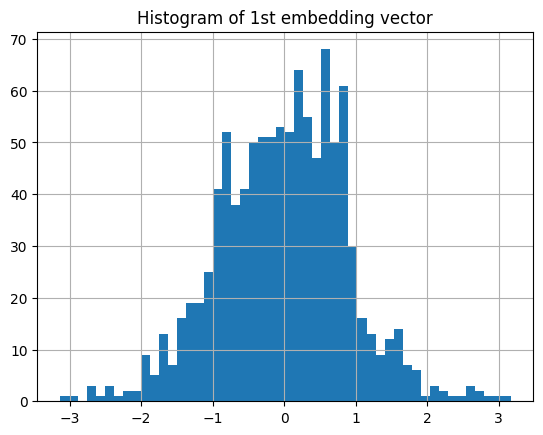

In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Pick 1000 random image indices
sample_idxs = random.sample(range(len(dataset.imgs)), 1000)
sample_images = [dataset.imgs[i] for i in sample_idxs]

# Query the API using your function
embs = model_stealing(sample_images, port="9732")  # your new port
embs = np.array(embs, dtype=np.float32)

# Print shape
print("✅ Received embeddings:", embs.shape)

# Plot histogram of one embedding
plt.hist(embs[0], bins=50)
plt.title("Histogram of 1st embedding vector")
plt.grid(True)
plt.show()
